In [1]:
import numpy as np
import torch
import sys
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import os
import pandas as pd

from torch.utils.data import DataLoader, Dataset, TensorDataset

import time
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

In [2]:
# from google.colab import drive
# drive.mount('/content/gdrive')

In [3]:
!ls

!pwd

Run1080_SP19_1139_generate.ipynb   Run1081_SP18_3323_generate.ipynb
Run1080_SP20_10838_generate.ipynb  Run1087_SP17_8693_generate.ipynb
Run1080_SP20_642_generate.ipynb    Run1087_SP18_8471_generate.ipynb
Run1080_SP21_213_generate.ipynb    Run1087_SP19_4061_generate.ipynb
Run1081_SP17_2566_generate.ipynb   Run1087_SP20_1098_generate.ipynb
/mnt/ufs18/home-144/dingjia5/projects/CosMx_kidney/benchmark_generation_scripts


### standard: fov in metadata_file, not Run1080_SP19_1139_fov_positions_file


# Transcript Data

In [4]:
import pandas as pd


In [5]:
gene_spatial = pd.read_csv('../Run1087_SP20_1098/Run1087_SP20_1098_tx_file.csv')
gene_spatial

,fov,cell_ID,x_global_px,y_global_px,x_local_px,y_local_px,z,target,CellComp
0,1,0,-521.788889,-22422.138889,5017.100,1416.750,7,VPREB3,Membrane
1,1,0,-197.928889,-23459.818889,5340.960,379.070,7,SMARCB1,None
2,1,0,-2253.788889,-23806.188889,3285.100,32.700,7,IL1RL1,None
3,1,0,-2073.918889,-20541.031889,3464.970,3297.857,7,STAT3,None
4,1,0,-877.888889,-21763.888889,4661.000,2075.000,7,PSCA,None
...,...,...,...,...,...,...,...,...,...
8676569,17,2295,36663.784444,7825.951111,819.340,14.840,8,EIF5A,Membrane
8676570,17,2295,36667.230444,7830.741111,822.786,19.630,8,ARF1,Membrane
8676571,17,2295,36666.924444,7830.571111,822.480,19.460,8,ARHGDIB,Membrane
8676572,17,2295,36667.427444,7830.491111,822.983,19.380,8,CCR7,Membrane


In [6]:
gene_spatial.shape

(8676574, 9)

In [7]:
min(gene_spatial["x_global_px"]), max(gene_spatial["x_global_px"])

(-5529.18888888889, 56896.1688888889)

In [8]:
min(gene_spatial["y_global_px"]), max(gene_spatial["y_global_px"])

(-23828.2688888889, 11443.8911111111)

In [9]:
min(gene_spatial["x_local_px"]), max(gene_spatial["x_local_px"])

(9.34, 5461.65)

In [10]:
min(gene_spatial["y_local_px"]), max(gene_spatial["y_local_px"])

(10.3699999999999, 3637.95)

In [11]:
gene_spatial.loc[gene_spatial['fov']==9].shape

(352798, 9)

In [12]:
gene_spatial.loc[gene_spatial['fov']==9].shape

(352798, 9)

In [13]:
filtered_data_fov1_cell_ID_1 =  gene_spatial[(gene_spatial['fov']==9) & (gene_spatial['cell_ID']==1)]
filtered_data_fov1_cell_ID_1

,fov,cell_ID,x_global_px,y_global_px,x_local_px,y_local_px,z,target,CellComp
6696312,9,1,36911.213333,-3322.788889,1877.88,3616.1000,7,CLEC7A,Nuclear
6696313,9,1,36924.033333,-3313.188889,1890.70,3625.7000,6,NOD2,Nuclear
6696314,9,1,36923.853333,-3313.188889,1890.52,3625.7000,6,PTGDR2,Nuclear
6696315,9,1,36923.963333,-3312.988889,1890.63,3625.9000,6,RSPO1,Nuclear
6696316,9,1,36923.923333,-3313.401389,1890.59,3625.4875,6,CD36,Nuclear
...,...,...,...,...,...,...,...,...,...
6697008,9,1,36909.503333,-3309.255589,1876.17,3629.6333,13,SPARCL1,Nuclear
6697009,9,1,36881.083333,-3313.988889,1847.75,3624.9000,13,FGF9,Cytoplasm
6697010,9,1,36921.783333,-3314.763889,1888.45,3624.1250,13,ITGB8,Nuclear
6697011,9,1,36892.283333,-3330.638889,1858.95,3608.2500,8,BMP4,Cytoplasm


In [14]:
gene_expression = pd.read_csv('../Run1087_SP20_1098/Run1087_SP20_1098_exprMat_file.csv')
gene_expression

,fov,cell_ID,AATK,ABL1,ABL2,ACE,ACE2,ACKR1,ACKR3,ACKR4,...,NegPrb13,NegPrb14,NegPrb15,NegPrb16,NegPrb18,NegPrb19,NegPrb20,NegPrb21,NegPrb22,NegPrb23
0,1,0,23,27,40,34,74,23,32,23,...,15,21,19,21,28,24,38,16,30,40
1,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,2,0,0,0,1,1,0,1,0,...,0,0,0,0,1,0,0,0,0,0
3,1,3,0,0,0,0,2,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,1,4,0,2,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42403,17,2294,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
42404,17,2295,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
42405,17,2296,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
42406,17,2297,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [15]:
gene_expression.shape

(42408, 981)

In [16]:
cell_boundary = pd.read_csv('../Run1087_SP20_1098/Run1087_SP20_1098_metadata_file.csv')
cell_boundary


,fov,cell_ID,Area,AspectRatio,CenterX_local_px,CenterY_local_px,CenterX_global_px,CenterY_global_px,Width,Height,Mean.MembraneStain,Max.MembraneStain,Mean.G,Max.G,Mean.Y,Max.Y,Mean.R,Max.R,Mean.DAPI,Max.DAPI
0,1,1,4615,1.00,4491,3505,-1047.888889,-20333.888889,82,82,2329,6771,139,644,5,3822,15,297,241,1194
1,1,2,4095,0.83,4965,3482,-573.888889,-20356.888889,70,84,2597,6635,314,1157,5,3978,48,317,245,1188
2,1,3,3389,1.40,4560,3469,-978.888889,-20369.888889,84,60,2130,3784,304,791,2,176,50,362,245,970
3,1,4,4635,1.20,4438,3466,-1100.888889,-20372.888889,96,80,4310,10016,535,6154,27,8293,22,497,70,945
4,1,5,4777,1.13,5003,3459,-535.888889,-20379.888889,90,80,2976,5847,325,4044,18,6085,46,783,173,1146
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42386,17,2294,2962,1.49,3623,26,39467.444444,7837.111111,73,49,1183,2333,142,738,5,100,18,191,426,1343
42387,17,2295,1880,2.55,780,18,36624.444444,7829.111111,84,33,26418,64079,802,2831,0,33,4,175,555,2061
42388,17,2296,2909,1.74,1030,25,36874.444444,7836.111111,82,47,5944,20207,51,488,0,0,0,145,586,2730
42389,17,2297,2225,1.59,964,22,36808.444444,7833.111111,65,41,7686,56821,187,1344,4,305,2,249,371,2571


In [17]:
min(cell_boundary["CenterX_global_px"]), max(cell_boundary["CenterX_global_px"])

(-5516.88888888889, 56888.8888888889)

In [18]:
min(cell_boundary["CenterY_global_px"]), max(cell_boundary["CenterY_global_px"])

(-23821.8888888889, 11439.1111111111)

In [19]:
cell_boundary_fov_1 =  cell_boundary[(cell_boundary['fov']==9)]
cell_boundary_fov_1

,fov,cell_ID,Area,AspectRatio,CenterX_local_px,CenterY_local_px,CenterX_global_px,CenterY_global_px,Width,Height,Mean.MembraneStain,Max.MembraneStain,Mean.G,Max.G,Mean.Y,Max.Y,Mean.R,Max.R,Mean.DAPI,Max.DAPI
25140,9,1,3080,1.80,1878,3625,36911.333333,-3313.888889,83,46,3980,8984,12,7221,23,9972,2,1135,700,2381
25141,9,2,9535,2.16,4080,3610,39113.333333,-3328.888889,164,76,13998,53111,165,5468,3,1853,0,124,309,2348
25142,9,3,4736,1.19,4433,3608,39466.333333,-3330.888889,95,80,18248,64063,7837,60732,122,1213,189,1533,374,2347
25143,9,4,3592,1.40,4488,3618,39521.333333,-3320.888889,84,60,44880,64159,2481,10588,85,8438,6,1135,5,538
25144,9,5,1692,1.58,4613,3628,39646.333333,-3310.888889,63,40,38329,63935,3004,8357,22,1098,3,200,0,253
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27140,9,2001,786,1.62,5069,16,40102.333333,-6922.888889,47,29,1350,2106,15,584,31,3847,3,305,958,1519
27141,9,2002,3381,2.19,5287,23,40320.333333,-6915.888889,94,43,1261,3050,1533,8979,0,43,11,197,362,1237
27142,9,2003,1645,2.24,4448,16,39481.333333,-6922.888889,65,29,1228,1712,26,152,0,73,4,108,321,826
27143,9,2004,1633,1.94,4950,18,39983.333333,-6920.888889,64,33,1306,2815,17,5939,15,6482,4,206,519,1752


In [20]:
type(cell_boundary_fov_1)
# cell_boundary_fov_1.to_csv('sample_fov2.csv')

pandas.core.frame.DataFrame

In [21]:
cell_boundary_fov_1.iloc[0]["CenterX_local_px"]

1878.0

In [22]:
cell_boundary_fov_1.iloc[0]["CenterY_local_px"]

3625.0

In [23]:
min(cell_boundary_fov_1["CenterX_local_px"]), max(cell_boundary_fov_1["CenterX_local_px"])

(21, 5454)

In [24]:
min(cell_boundary_fov_1["CenterY_local_px"]), max(cell_boundary_fov_1["CenterY_local_px"])

(9, 3637)

In [25]:
fov_position = pd.read_csv('../Run1087_SP20_1098/Run1087_SP20_1098_fov_positions_file.csv')

# fov_position = pd.read_csv('../Run1080_SP20_10838/Run1080_SP20_10838_fov_positions_file.csv')
fov_position

,fov,x_global_px,y_global_px
0,1,-5538.888889,-23838.888889
1,2,400.000000,-21316.666667
2,3,6233.333333,-17255.555556
3,4,7533.333333,-13600.000000
4,5,13144.444444,-12350.000000
5,6,18611.111111,-10461.111111
6,7,24088.888889,-8872.222222
7,8,29561.111111,-7783.333333
8,9,35033.333333,-6938.888889
9,10,40505.555556,-6933.333333


In [36]:
x_coordinate = [x / 10000 for x in list(fov_position["x_global_px"])]
x_coordinate

[-0.553888888888889,
 0.04,
 0.6233333333333331,
 0.7533333333333331,
 1.31444444444444,
 1.8611111111111098,
 2.40888888888889,
 2.95611111111111,
 3.50333333333333,
 4.05055555555556,
 4.597777777777781,
 5.14388888888889,
 0.482777777777778,
 1.68,
 2.22722222222222,
 2.7744444444444403,
 3.5844444444444403,
 -4.32555555555556,
 -3.655,
 -3.38833333333333,
 -3.10777777777778,
 -2.84888888888889,
 -2.73,
 -2.65,
 -3.91833333333333]

In [37]:
y_coordinate = [y / 10000 for y in list(fov_position["y_global_px"])]
y_coordinate

[-2.3838888888888903,
 -2.13166666666667,
 -1.72555555555556,
 -1.36,
 -1.235,
 -1.04611111111111,
 -0.8872222222222221,
 -0.778333333333333,
 -0.693888888888889,
 -0.693333333333333,
 -0.703888888888889,
 -0.474444444444444,
 -0.0905555555555556,
 0.365,
 0.447777777777778,
 0.569444444444444,
 0.7811111111111111,
 2.19611111111111,
 0.842777777777778,
 0.21,
 -0.160555555555556,
 -0.787777777777778,
 -1.15444444444444,
 -1.51888888888889,
 -2.0088888888888903]

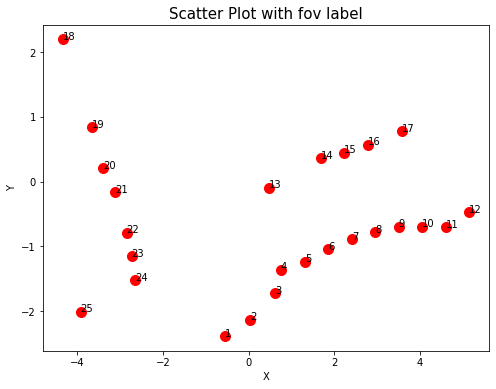

In [38]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(20)

X=np.random.randint(10, size=(5))
Y=np.random.randint(10, size=(5))

X = x_coordinate
Y = y_coordinate

annotations=["Point-1","Point-2","Point-3","Point-4","Point-5"]
annotations = list(fov_position["fov"])

plt.figure(figsize=(8,6))
plt.scatter(X,Y,s=100,color="red")
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Scatter Plot with fov label",fontsize=15)
for i, label in enumerate(annotations):
    plt.annotate(label, (X[i], Y[i]))

plt.show()

In [39]:

fov_spot_coordinates = pd.DataFrame(columns = ['fov', 'spot_id', 'x', 'y'])
fov_spot_coordinates                                               

,fov,spot_id,x,y


In [26]:


def get_spot_x_y_range(x_global_px, y_global_px, fov_id, fov_spot_coordinates):
    fov_length = 5472
    fov_width = 3648
    x_l = x_global_px
    y_l = y_global_px
    x_h = x_l + fov_length
    y_h = y_l + fov_width
    
    spot_id = 1
    x = x_l + (5472/10.0) * 1
    y = y_h - (3648/8.0) * 1
    fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)

    spot_id = 2
    x = x_l + (5472/10.0) * 1
    y = y_h - (3648/8.0) * 1 - (3648/4.0) * 1
    fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)

    spot_id = 3
    x = x_l + (5472/10.0) * 1
    y = y_h - (3648/8.0) * 1 - (3648/4.0) * 2
    fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)
   
    spot_id = 4
    x = x_l + (5472/10.0) * 1
    y = y_h - (3648/8.0) * 1 - (3648/4.0) * 3
    fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)

    # ---------
    spot_id = 5
    x = x_l + (5472/10.0) * 1 + (5472/5.0) * 1
    y = y_h - (3648/8.0) * 1
    fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)

    spot_id = 6
    x = x_l + (5472/10.0) * 1 + (5472/5.0) * 1
    y = y_h - (3648/8.0) * 1 - (3648/4.0) * 1
    fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)

    spot_id = 7
    x = x_l + (5472/10.0) * 1 + (5472/5.0) * 1
    y = y_h - (3648/8.0) * 1 - (3648/4.0) * 2
    fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)
   
    spot_id = 8
    x = x_l + (5472/10.0) * 1 + (5472/5.0) * 1
    y = y_h - (3648/8.0) * 1 - (3648/4.0) * 3
    fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)
   
   # -----------
    spot_id = 9
    x = x_l + (5472/10.0) * 1 + (5472/5.0) * 2
    y = y_h - (3648/8.0) * 1
    fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)

    spot_id = 10
    x = x_l + (5472/10.0) * 1 + (5472/5.0) * 2
    y = y_h - (3648/8.0) * 1 - (3648/4.0) * 1
    fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)

    spot_id = 11
    x = x_l + (5472/10.0) * 1 + (5472/5.0) * 2
    y = y_h - (3648/8.0) * 1 - (3648/4.0) * 2
    fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)
   
    spot_id = 12
    x = x_l + (5472/10.0) * 1 + (5472/5.0) * 2
    y = y_h - (3648/8.0) * 1 - (3648/4.0) * 3
    fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)

    # -----------
    spot_id = 13
    x = x_l + (5472/10.0) * 1 + (5472/5.0) * 3
    y = y_h - (3648/8.0) * 1
    fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)

    spot_id = 14
    x = x_l + (5472/10.0) * 1 + (5472/5.0) * 3
    y = y_h - (3648/8.0) * 1 - (3648/4.0) * 1
    fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)

    spot_id = 15
    x = x_l + (5472/10.0) * 1 + (5472/5.0) * 3
    y = y_h - (3648/8.0) * 1 - (3648/4.0) * 2
    fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)
   
    spot_id = 16
    x = x_l + (5472/10.0) * 1 + (5472/5.0) * 3
    y = y_h - (3648/8.0) * 1 - (3648/4.0) * 3
    fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)
   
    # -----------
    spot_id = 17
    x = x_l + (5472/10.0) * 1 + (5472/5.0) * 4
    y = y_h - (3648/8.0) * 1
    fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)

    spot_id = 18
    x = x_l + (5472/10.0) * 1 + (5472/5.0) * 4
    y = y_h - (3648/8.0) * 1 - (3648/4.0) * 1
    fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)

    spot_id = 19
    x = x_l + (5472/10.0) * 1 + (5472/5.0) * 4
    y = y_h - (3648/8.0) * 1 - (3648/4.0) * 2
    fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)
   
    spot_id = 20
    x = x_l + (5472/10.0) * 1 + (5472/5.0) * 4
    y = y_h - (3648/8.0) * 1 - (3648/4.0) * 3
    fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)
    
    
    fov_spot_coordinates['x'] = fov_spot_coordinates['x'] 
    fov_spot_coordinates['y'] = fov_spot_coordinates['y']
    
    return fov_spot_coordinates
    

In [27]:
coordinates = get_spot_x_y_range(-25727.777778, -164066.666667, 8, fov_spot_coordinates)
coordinates

NameError: name 'fov_spot_coordinates' is not defined

# Benchmark Generation

In [33]:
"""
1 μm(micrometer) = 1e-4 cm
GeoMx: spot region area
1. mean: 37456.28 μm2
2. median: 24168.74 μm2
"""

'\nGeoMx: spot region area\n1. mean: 37456.28 μm2\n2. median: 24168.74 μm2\n'

In [34]:
"""
CosMx lung: 
1. All FOVs are the same dimension, 5472 x 3648 pixels
2. multiply the pixel value by 0.18 um per pixel
3. FOV area: 5472 x 3648 pixels -> 984.96um x 656.64um = 646,764.134 um2 
"""

'\nCosMx lung: \n1. All FOVs are the same dimension, 5472 x 3648 pixels\n2. multiply the pixel value by 0.18 um per pixel\n3. FOV area: 5472 x 3648 pixels -> 984.96um x 656.64um = 646,764.134 um2 \n'

In [35]:
"""
New Benchamrk from CosMx
1. length: 5472 pixels, width: 3648 pixels
2. simulated spot: 
    length: 5472 pixels / 5 = 1094.4 pixel = 196.992 um
    width: 3648 pixels / 4 = 912 pixel = 164.16 um
    one spot area: 196.992 um * 164.16 um = 32338.2067 um2
3. In total: 20 spots / FOV
"""

'\nNew Benchamrk from CosMx\n1. length: 5472 pixels, width: 3648 pixels\n2. simulated spot: \n    length: 5472 pixels / 5 = 1094.4 pixel = 196.992 um\n    width: 3648 pixels / 4 = 912 pixel = 164.16 um\n    one spot area: 196.992 um * 164.16 um = 32338.2067 um2\n3. In total: 20 spots / FOV\n'

In [36]:
"""
CosMx Kidey dataset:
Assume FOV size on kidney is 5472 x 3648 pixels.

so the pseudo spot still be: 
    length: 5472 pixels / 5 = 1094.4 pixel = 196.992 um
    width: 3648 pixels / 4 = 912 pixel = 164.16 um

"""

'\nCosMx Kidey dataset:\nAssume FOV size on kidney is 5472 x 3648 pixels.\n\nso the pseudo spot still be: \n    length: 5472 pixels / 5 = 1094.4 pixel = 196.992 um\n    width: 3648 pixels / 4 = 912 pixel = 164.16 um\n\n'

In [37]:
"""
spot_fov_cellId_mapping.csv (spot_id, fov, cell_Id)

spot_gene_expression.csv (spot_id, gene1, gene2, gene3...)
"""

'\nspot_fov_cellId_mapping.csv (spot_id, fov, cell_Id)\n\nspot_gene_expression.csv (spot_id, gene1, gene2, gene3...)\n'

## 1. spot_fov_cellId_mapping.csv

In [ ]:
def get_spot_fov_cellId_mapping(data_result, cell_boundary_fov_11):
    new_col_val = cell_boundary_fov_11.shape[0]* [0]
    cell_boundary_fov_11.insert(loc=0, column='spot_id', value=new_col_val)

    for i in range(cell_boundary_fov_11.shape[0]):
        one_row_sample = cell_boundary_fov_11.iloc[i]
        if one_row_sample["CenterX_local_px"] <= 1094.4 * 1:
            if one_row_sample["CenterY_local_px"] <= 912 * 1:
                spot_id = 1
            elif one_row_sample["CenterY_local_px"] <= 912 * 2:
                spot_id = 2
            elif one_row_sample["CenterY_local_px"] <= 912 * 3:
                spot_id = 3
            elif one_row_sample["CenterY_local_px"] <= 912 * 4:
                spot_id = 4

        elif one_row_sample["CenterX_local_px"] <= 1094.4 * 2:
            if one_row_sample["CenterY_local_px"] <= 912 * 1:
                spot_id = 5
            elif one_row_sample["CenterY_local_px"] <= 912 * 2:
                spot_id = 6
            elif one_row_sample["CenterY_local_px"] <= 912 * 3:
                spot_id = 7
            elif one_row_sample["CenterY_local_px"] <= 912 * 4:
                spot_id = 8

        elif one_row_sample["CenterX_local_px"] <= 1094.4 * 3:
            if one_row_sample["CenterY_local_px"] <= 912 * 1:
                spot_id = 9
            elif one_row_sample["CenterY_local_px"] <= 912 * 2:
                spot_id = 10
            elif one_row_sample["CenterY_local_px"] <= 912 * 3:
                spot_id = 11
            elif one_row_sample["CenterY_local_px"] <= 912 * 4:
                spot_id = 12

        elif one_row_sample["CenterX_local_px"] <= 1094.4 * 4:
            if one_row_sample["CenterY_local_px"] <= 912 * 1:
                spot_id = 13
            elif one_row_sample["CenterY_local_px"] <= 912 * 2:
                spot_id = 14
            elif one_row_sample["CenterY_local_px"] <= 912 * 3:
                spot_id = 15
            elif one_row_sample["CenterY_local_px"] <= 912 * 4:
                spot_id = 16

        elif one_row_sample["CenterX_local_px"] <= 1094.4 * 5:
            if one_row_sample["CenterY_local_px"] <= 912 * 1:
                spot_id = 17
            elif one_row_sample["CenterY_local_px"] <= 912 * 2:
                spot_id = 18
            elif one_row_sample["CenterY_local_px"] <= 912 * 3:
                spot_id = 19
            elif one_row_sample["CenterY_local_px"] <= 912 * 4:
                spot_id = 20
        else:
            print("Wrong CenterX_local_px")
        data_result = data_result.append({'spot_id' : spot_id, 'fov' : one_row_sample["fov"], 'cell_ID' : one_row_sample["cell_ID"]}, ignore_index = True)

    return data_result

        

In [ ]:
data_final_result = pd.DataFrame(columns = [ 'fov', 'spot_id', 'cell_ID'])
data_final_result

In [ ]:
cell_boundary

In [ ]:
type(cell_boundary)

In [29]:
fov_ids_lst = cell_boundary['fov'].unique()
fov_ids_lst

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17])

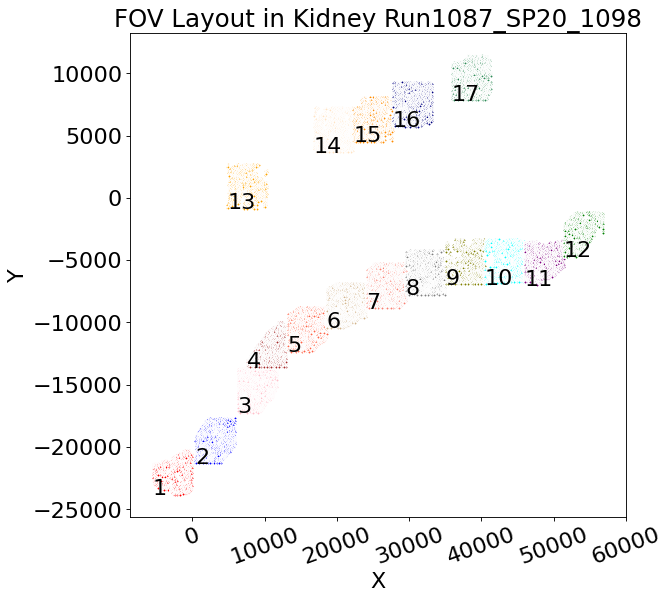

In [30]:
import numpy as np
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 8), dpi=80)

np.random.seed(20)
color = ["red", "blue", "pink", "brown", "tomato", "tan", "salmon", "gray", "olive", \
         "cyan", "purple", "green", "orange", "bisque", "darkorange", "navy", "seagreen", \
         "gold", "teal", "peru", "lightpink", "teal", "plum", "violet", "lavender", "khaki",\
        "red", "blue", "pink", "brown", "tomato", "tan", "salmon", "gray", "olive",\
        "cyan", "purple", "green", "orange", "bisque", "darkorange", "navy", "seagreen",\
        "gold", "teal", "peru", "lightpink", "teal", "plum", "violet", "lavender", "khaki",\
         "red", "blue", "pink", "brown", "tomato", "tan", "salmon", "gray", "olive", \
         "cyan", "purple", "green", "orange", "bisque", "darkorange", "navy", "seagreen", \
         "gold", "teal", "peru", "lightpink", "teal", "plum", "violet", "lavender", "khaki"
        ]
for i in range(len(fov_ids_lst)):
    fov_id = fov_ids_lst[i]
    X = cell_boundary[(cell_boundary['fov']==fov_id)]["CenterX_global_px"].tolist()
    Y = cell_boundary[(cell_boundary['fov']==fov_id)]["CenterY_global_px"].tolist()

    plt.scatter(X, Y, s=30, label = fov_id, c = color[i], marker='.', alpha = None, edgecolors= 'white')
#     plt.legend()

X = fov_position["x_global_px"].tolist()
Y = fov_position["y_global_px"].tolist()

X_plus = [i+ 5472 for i in X]
Y_plus = [i+3648 for i in Y]

annotations=["Point-1","Point-2","Point-3","Point-4","Point-5"]
annotations = (fov_position["fov"]).tolist()

# plt.scatter(X,Y,s=10,color="red")
# plt.scatter(X_plus, Y_plus,s=10,color="red")
# plt.scatter(X_plus, Y,s=10,color="red")
# plt.scatter(X, Y_plus,s=10,color="red")

plt.xticks(fontsize=20, rotation=20)
plt.yticks(fontsize=20)
plt.xlabel('X', fontsize=20)
plt.ylabel('Y', fontsize=20)
plt.title("FOV Layout in Kidney Run1087_SP20_1098",fontsize=22)
for i, label in enumerate(annotations):
    plt.annotate(label, (X[i], Y[i]), size=20)

plt.savefig("../../FOV_layout/kidney_Run1087_SP20_1098.png", format="png", bbox_inches="tight")
plt.show()


In [ ]:
for fov_id in fov_ids_lst:
    print("fov_id:", fov_id, cell_boundary[(cell_boundary['fov']==fov_id)].shape)

In [48]:
cell_boundary[(cell_boundary['fov']==14)]["CenterX_global_px"].tolist()

[19818.0,
 19887.0,
 20598.0,
 20664.0,
 19755.0,
 22049.0,
 19821.0,
 19440.0,
 18534.0,
 22106.0,
 21678.0,
 19447.0,
 19751.0,
 19783.0,
 20666.0,
 20803.0,
 20882.0,
 21581.0,
 21430.0,
 19988.0,
 21175.0,
 20955.0,
 19822.0,
 20678.0,
 19578.0,
 19934.0,
 17043.0,
 20778.0,
 20866.0,
 21103.0,
 21832.0,
 19612.0,
 21719.0,
 20668.0,
 22038.0,
 21682.0,
 21086.0,
 21768.0,
 21173.0,
 21485.0,
 19740.0,
 21780.0,
 22201.0,
 22077.0,
 22139.0,
 21278.0,
 21516.0,
 20747.0,
 21572.0,
 21657.0,
 21238.0,
 19696.0,
 19804.0,
 22029.0,
 19947.0,
 20337.0,
 21834.0,
 21461.0,
 22038.0,
 20878.0,
 20954.0,
 21625.0,
 22220.0,
 22052.0,
 20841.0,
 21944.0,
 19274.0,
 19612.0,
 19951.0,
 22152.0,
 20900.0,
 20814.0,
 22230.0,
 19815.0,
 22063.0,
 19654.0,
 19747.0,
 20961.0,
 18337.0,
 18965.0,
 22237.0,
 19125.0,
 20429.0,
 19879.0,
 21575.0,
 21947.0,
 20913.0,
 21872.0,
 22157.0,
 19189.0,
 20854.0,
 22257.0,
 22056.0,
 18155.0,
 19730.0,
 19086.0,
 21827.0,
 19044.0,
 22153.0,
 18964.0,


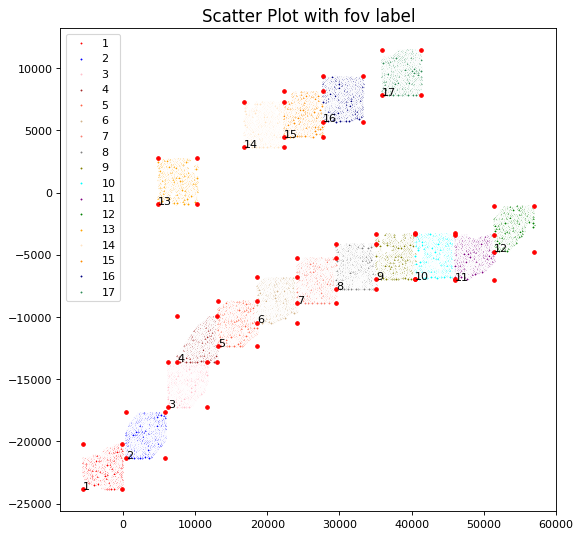

In [50]:
import numpy as np
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 8), dpi=80)

np.random.seed(20)
color = ["red", "blue", "pink", "brown", "tomato", "tan", "salmon", "gray", "olive", "cyan", "purple", "green", "orange", "bisque", "darkorange", "navy", "seagreen", "gold", "teal"]
for i in range(len(fov_ids_lst)):
    fov_id = fov_ids_lst[i]
    X = cell_boundary[(cell_boundary['fov']==fov_id)]["CenterX_global_px"].tolist()
    Y = cell_boundary[(cell_boundary['fov']==fov_id)]["CenterY_global_px"].tolist()

    plt.scatter(X, Y, s=30, label = fov_id, c = color[i], marker='.', alpha = None, edgecolors= 'white')
    plt.legend()

X = fov_position["x_global_px"].tolist()[:17]
Y = fov_position["y_global_px"].tolist()[:17]

X_plus = [i+ 5472 for i in X]
Y_plus = [i+3648 for i in Y]

annotations=["Point-1","Point-2","Point-3","Point-4","Point-5"]
annotations = (fov_position["fov"]).tolist()[:17]

plt.scatter(X,Y,s=10,color="red")
plt.scatter(X_plus, Y_plus,s=10,color="red")
plt.scatter(X_plus, Y,s=10,color="red")
plt.scatter(X, Y_plus,s=10,color="red")


plt.title("Scatter Plot with fov label",fontsize=15)
for i, label in enumerate(annotations):
    plt.annotate(label, (X[i], Y[i]))


plt.show()


In [51]:
fov_ids_lst = cell_boundary['fov'].unique()
print("fov_ids_lst:", fov_ids_lst)

for fov_id in fov_ids_lst:
    print("fov_id:", fov_id)
    cell_boundary_fov =  cell_boundary[(cell_boundary['fov']==fov_id)]
    print("cell_boundary_fov_without_spot_id:", cell_boundary_fov.shape)
    data_final_result = get_spot_fov_cellId_mapping(data_final_result, cell_boundary_fov)

data_final_result

fov_ids_lst: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]
fov_id: 1
cell_boundary_fov_without_spot_id: (2181, 20)
fov_id: 2
cell_boundary_fov_without_spot_id: (3223, 20)
fov_id: 3
cell_boundary_fov_without_spot_id: (3305, 20)
fov_id: 4
cell_boundary_fov_without_spot_id: (2886, 20)
fov_id: 5
cell_boundary_fov_without_spot_id: (3641, 20)
fov_id: 6
cell_boundary_fov_without_spot_id: (3587, 20)
fov_id: 7
cell_boundary_fov_without_spot_id: (3260, 20)
fov_id: 8
cell_boundary_fov_without_spot_id: (3057, 20)
fov_id: 9
cell_boundary_fov_without_spot_id: (2005, 20)
fov_id: 10
cell_boundary_fov_without_spot_id: (2146, 20)
fov_id: 11
cell_boundary_fov_without_spot_id: (2452, 20)
fov_id: 12
cell_boundary_fov_without_spot_id: (1642, 20)
fov_id: 13
cell_boundary_fov_without_spot_id: (1246, 20)
fov_id: 14
cell_boundary_fov_without_spot_id: (1593, 20)
fov_id: 15
cell_boundary_fov_without_spot_id: (1734, 20)
fov_id: 16
cell_boundary_fov_without_spot_id: (2135, 20)
fov_id: 17
cell_boundary_fov_wi

,fov,spot_id,cell_ID
0,1.0,20.0,1.0
1,1.0,20.0,2.0
2,1.0,20.0,3.0
3,1.0,20.0,4.0
4,1.0,20.0,5.0
...,...,...,...
42386,17.0,13.0,2294.0
42387,17.0,1.0,2295.0
42388,17.0,1.0,2296.0
42389,17.0,1.0,2297.0


In [52]:
data_final_result

,fov,spot_id,cell_ID
0,1.0,20.0,1.0
1,1.0,20.0,2.0
2,1.0,20.0,3.0
3,1.0,20.0,4.0
4,1.0,20.0,5.0
...,...,...,...
42386,17.0,13.0,2294.0
42387,17.0,1.0,2295.0
42388,17.0,1.0,2296.0
42389,17.0,1.0,2297.0


In [53]:
data_final_result_sample = data_final_result[(data_final_result['fov']==14)]
data_final_result_sample

,fov,spot_id,cell_ID
34631,14.0,12.0,1.0
34632,14.0,12.0,2.0
34633,14.0,16.0,3.0
34634,14.0,16.0,4.0
34635,14.0,12.0,5.0
...,...,...,...
36219,14.0,13.0,1589.0
36220,14.0,9.0,1590.0
36221,14.0,17.0,1591.0
36222,14.0,5.0,1592.0


In [54]:
data_final_result.to_csv('../Run1087_SP20_1098/new/spot_fov_cellId_mapping.csv')

In [55]:
data_final_result

,fov,spot_id,cell_ID
0,1.0,20.0,1.0
1,1.0,20.0,2.0
2,1.0,20.0,3.0
3,1.0,20.0,4.0
4,1.0,20.0,5.0
...,...,...,...
42386,17.0,13.0,2294.0
42387,17.0,1.0,2295.0
42388,17.0,1.0,2296.0
42389,17.0,1.0,2297.0


## 2. spot_gene_expression.csv

In [56]:
data_final_result = pd.read_csv('../Run1087_SP20_1098/new/spot_fov_cellId_mapping.csv')
data_final_result

,Unnamed: 0,fov,spot_id,cell_ID
0,0,1.0,20.0,1.0
1,1,1.0,20.0,2.0
2,2,1.0,20.0,3.0
3,3,1.0,20.0,4.0
4,4,1.0,20.0,5.0
...,...,...,...,...
42386,42386,17.0,13.0,2294.0
42387,42387,17.0,1.0,2295.0
42388,42388,17.0,1.0,2296.0
42389,42389,17.0,1.0,2297.0


In [57]:
gene_expression

,fov,cell_ID,AATK,ABL1,ABL2,ACE,ACE2,ACKR1,ACKR3,ACKR4,...,NegPrb13,NegPrb14,NegPrb15,NegPrb16,NegPrb18,NegPrb19,NegPrb20,NegPrb21,NegPrb22,NegPrb23
0,1,0,23,27,40,34,74,23,32,23,...,15,21,19,21,28,24,38,16,30,40
1,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,2,0,0,0,1,1,0,1,0,...,0,0,0,0,1,0,0,0,0,0
3,1,3,0,0,0,0,2,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,1,4,0,2,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42403,17,2294,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
42404,17,2295,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
42405,17,2296,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
42406,17,2297,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [58]:
fov_spot_cells_stats = pd.DataFrame(columns = ['fov', 'spot-id=1', 'spot-id=2', 'spot-id=3','spot-id=4', 'spot-id=5', 'spot-id=6', 'spot-id=7', 'spot-id=8', 'spot-id=9','spot-id=10', 'spot-id=11', 'spot-id=12', 'spot-id=13','spot-id=14', 'spot-id=15', 'spot-id=16', 'spot-id=17', 'spot-id=18', 'spot-id=19','spot-id=20'])
fov_spot_cells_stats


,fov,spot-id=1,spot-id=2,spot-id=3,spot-id=4,spot-id=5,spot-id=6,spot-id=7,spot-id=8,spot-id=9,...,spot-id=11,spot-id=12,spot-id=13,spot-id=14,spot-id=15,spot-id=16,spot-id=17,spot-id=18,spot-id=19,spot-id=20


In [59]:
names = ['fov', 'spot-id=1', 'spot-id=2', 'spot-id=3','spot-id=4', 'spot-id=5', 'spot-id=6', 'spot-id=7', 'spot-id=8', 'spot-id=9','spot-id=10', 'spot-id=11', 'spot-id=12', 'spot-id=13','spot-id=14', 'spot-id=15', 'spot-id=16', 'spot-id=17', 'spot-id=18', 'spot-id=19','spot-id=20']
fov_dic = {}
for i in names:
    fov_dic[i] = 0
fov_dic



{'fov': 0,
 'spot-id=1': 0,
 'spot-id=2': 0,
 'spot-id=3': 0,
 'spot-id=4': 0,
 'spot-id=5': 0,
 'spot-id=6': 0,
 'spot-id=7': 0,
 'spot-id=8': 0,
 'spot-id=9': 0,
 'spot-id=10': 0,
 'spot-id=11': 0,
 'spot-id=12': 0,
 'spot-id=13': 0,
 'spot-id=14': 0,
 'spot-id=15': 0,
 'spot-id=16': 0,
 'spot-id=17': 0,
 'spot-id=18': 0,
 'spot-id=19': 0,
 'spot-id=20': 0}

In [60]:
fov_ids_lst = cell_boundary['fov'].unique()
spot_id_lst = [ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]

for fov_id in fov_ids_lst:
    fov_data = data_final_result[(data_final_result['fov']==fov_id)]
    
    fov_dic_sample = fov_dic
    fov_dic_sample["fov"] = fov_id
    
    for i in spot_id_lst:
        spot_id_data = fov_data[(fov_data['spot_id']==i)]
        spot_id_num = "spot-id=" + str(i)
        fov_dic_sample[spot_id_num] = spot_id_data.shape[0]
    fov_spot_cells_stats = fov_spot_cells_stats.append(fov_dic_sample, ignore_index = True)



In [61]:
fov_spot_cells_stats.to_csv('../Run1087_SP20_1098/new/fov_new_spot_cell_stats.csv')
fov_spot_cells_stats

,fov,spot-id=1,spot-id=2,spot-id=3,spot-id=4,spot-id=5,spot-id=6,spot-id=7,spot-id=8,spot-id=9,...,spot-id=11,spot-id=12,spot-id=13,spot-id=14,spot-id=15,spot-id=16,spot-id=17,spot-id=18,spot-id=19,spot-id=20
0,1,43,159,137,0,55,132,110,6,88,...,116,66,159,56,180,98,172,116,250,131
1,2,186,205,219,25,206,177,125,153,119,...,208,195,90,192,192,186,3,157,255,174
2,3,192,232,191,230,180,203,142,152,193,...,201,138,68,147,214,173,0,114,156,146
3,4,219,49,0,0,156,188,45,0,205,...,222,35,186,155,223,160,221,189,197,249
4,5,179,201,171,96,141,245,222,281,226,...,172,214,142,179,203,171,25,181,242,159
5,6,253,240,195,118,229,218,161,168,175,...,151,192,84,221,271,164,13,216,174,129
6,7,224,207,156,96,204,216,153,149,284,...,124,124,179,153,131,130,136,168,180,62
7,8,206,191,124,121,226,151,159,126,196,...,147,101,243,178,130,93,242,157,55,45
8,9,133,146,76,22,162,127,27,92,124,...,112,72,146,96,67,117,165,92,49,109
9,10,87,9,13,104,167,160,91,96,147,...,77,129,128,106,118,134,117,117,134,109


In [62]:
data_final_result[(data_final_result['fov']==fov_id)]

,Unnamed: 0,fov,spot_id,cell_ID
40093,40093,17.0,12.0,1.0
40094,40094,17.0,12.0,2.0
40095,40095,17.0,12.0,3.0
40096,40096,17.0,12.0,4.0
40097,40097,17.0,12.0,5.0
...,...,...,...,...
42386,42386,17.0,13.0,2294.0
42387,42387,17.0,1.0,2295.0
42388,42388,17.0,1.0,2296.0
42389,42389,17.0,1.0,2297.0


In [63]:
spot_gene_expression = ["fov", "spot_id"]
genes_name_lst = (gene_expression.columns)[2:].tolist()
spot_gene_expression = spot_gene_expression + genes_name_lst
spot_gene_expression

['fov',
 'spot_id',
 'AATK',
 'ABL1',
 'ABL2',
 'ACE',
 'ACE2',
 'ACKR1',
 'ACKR3',
 'ACKR4',
 'ACTA2',
 'ACTG2',
 'ACVR1',
 'ACVR1B',
 'ACVR2A',
 'ACVRL1',
 'ADGRA2',
 'ADGRA3',
 'ADGRB2',
 'ADGRB3',
 'ADGRD1',
 'ADGRE1',
 'ADGRE2',
 'ADGRE5',
 'ADGRF1',
 'ADGRF3',
 'ADGRF4',
 'ADGRF5',
 'ADGRG1',
 'ADGRG2',
 'ADGRG3',
 'ADGRG5',
 'ADGRG6',
 'ADGRL1',
 'ADGRL2',
 'ADGRL4',
 'ADGRV1',
 'ADIPOQ',
 'ADIRF',
 'ADM2',
 'ADORA2A',
 'AGR2',
 'AHI1',
 'AHR',
 'AKT1',
 'ALCAM',
 'ANGPT1',
 'ANGPT2',
 'ANGPT4',
 'ANGPTL1',
 'ANXA1',
 'ANXA2',
 'ANXA4',
 'APOA1',
 'APOB',
 'APOD',
 'APP',
 'AQP3',
 'AR',
 'AREG',
 'ARF1',
 'ARG1',
 'ARHGDIB',
 'ARTN',
 'ATF3',
 'ATG10',
 'ATG12',
 'ATG5',
 'ATM',
 'ATR',
 'AXL',
 'AZGP1',
 'AZU1',
 'B2M',
 'B3GNT7',
 'BAG3',
 'BATF3',
 'BAX',
 'BCL2',
 'BCL2L1',
 'BECN1',
 'BEST1',
 'BGN',
 'BID',
 'BIRC5',
 'BMP1',
 'BMP2',
 'BMP3',
 'BMP4',
 'BMP5',
 'BMP6',
 'BMP7',
 'BMPR1A',
 'BMPR2',
 'BMX',
 'BRCA1',
 'BST1',
 'BST2',
 'BTG1',
 'BTK',
 'C11orf96',
 'C1QA'

In [64]:
spot_gene_expression = pd.DataFrame(columns = spot_gene_expression)
spot_gene_expression


,fov,spot_id,AATK,ABL1,ABL2,ACE,ACE2,ACKR1,ACKR3,ACKR4,...,NegPrb13,NegPrb14,NegPrb15,NegPrb16,NegPrb18,NegPrb19,NegPrb20,NegPrb21,NegPrb22,NegPrb23


In [65]:
def get_spot_gene_expression(spot_cell_mapping, fov_expression, spot_id):
    genes_lst = (fov_expression.columns)[2:].tolist()
    
#     gene_count_dic = {}
#     for gene_name in genes_lst:
#         gene_count_dic[gene_name] = 0
    
    cell_id_lst = spot_cell_mapping[(spot_cell_mapping['spot_id']==spot_id)]["cell_ID"].tolist()
    
    cell_gene_expression_total = len(genes_lst)*[0]
    for cell_id in cell_id_lst:
        cell_gene_expression = fov_expression[(fov_expression['cell_ID'] == cell_id)]
        cell_gene_expression = cell_gene_expression.values.tolist()[0][2:]
        cell_gene_expression_total = np.sum([cell_gene_expression_total, cell_gene_expression], axis=0).tolist()
                
#         for gene_name in genes_lst:
#             gene_count_dic[gene_name] = gene_count_dic[gene_name] + cell_gene_expression[gene_name]
    
    return cell_gene_expression_total
    
    
    
        
    
    

In [66]:
fov_ids_lst = cell_boundary['fov'].unique()
spot_id_lst = [ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]

for fov_id in fov_ids_lst:
    fov_data = data_final_result[(data_final_result['fov']==fov_id)]
    print("fov_id:", fov_id)
#     print("fov_data", fov_data)
    fov_gene_expression = gene_expression[(gene_expression['fov'] == fov_id)]
#     print("fov_gene_expression:", fov_gene_expression)
    
    for spot_id in spot_id_lst:
        to_append = [fov_id, spot_id]
        spot_gene_express = get_spot_gene_expression(fov_data, fov_gene_expression, spot_id)
        to_append = to_append + spot_gene_express
        a_series = pd.Series(to_append, index = spot_gene_expression.columns)
        spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
       
#     print(spot_gene_express, len(spot_gene_express))
    
    
  

fov_id: 1
fov_id: 2
fov_id: 3
fov_id: 4
fov_id: 5
fov_id: 6
fov_id: 7
fov_id: 8
fov_id: 9
fov_id: 10
fov_id: 11
fov_id: 12
fov_id: 13
fov_id: 14
fov_id: 15
fov_id: 16
fov_id: 17


In [67]:
spot_gene_expression

,fov,spot_id,AATK,ABL1,ABL2,ACE,ACE2,ACKR1,ACKR3,ACKR4,...,NegPrb13,NegPrb14,NegPrb15,NegPrb16,NegPrb18,NegPrb19,NegPrb20,NegPrb21,NegPrb22,NegPrb23
0,1,1,2,4,6,2,4,2,2,2,...,1,1,1,1,2,4,1,0,3,0
1,1,2,1,3,6,1,14,1,9,2,...,6,3,5,5,6,9,4,1,8,5
2,1,3,4,8,13,10,45,4,6,3,...,6,3,6,4,9,4,7,6,6,6
3,1,4,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,5,5,4,6,5,22,3,3,9,...,4,1,4,3,9,4,8,4,8,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
335,17,16,5,3,6,8,12,3,11,10,...,3,1,2,3,2,3,3,8,5,5
336,17,17,17,8,14,42,5,2,22,9,...,12,0,19,4,16,23,9,17,6,13
337,17,18,10,7,7,12,3,5,6,7,...,4,1,7,4,8,10,4,4,5,7
338,17,19,20,6,9,8,8,3,12,6,...,5,4,4,3,5,11,1,4,5,4


In [68]:
spot_gene_expression.to_csv('../Run1087_SP20_1098/new/spot_gene_expression.csv')

## 3. Ground Truth

In [75]:
CosMx_cell_type = pd.read_csv('../cell_type/annot.csv')
CosMx_cell_type

,Unnamed: 0,cell_ID,fov,Area,AspectRatio,Width,Height,Mean.CD298,Max.CD298,Mean.PanCK,...,totalcounts,log10totalcounts,background,remove_flagged_cells,IFcolor,nb_clus,leiden_clus,negmean,class,cell_type
0,1,c_1_13_1,13,4002,1.60,88,55,11986,28069,5650,...,20,1.301030,0.006710,False,#4A5202FF,NotDet,5,0.05,III,Podocyte
1,2,c_1_13_2,13,5472,1.90,116,61,15688,33560,194,...,632,2.800717,0.212033,False,#050300FF,a,7,0.50,III,Proliferating.Proximal.Tubule
2,3,c_1_13_3,13,4925,1.42,95,67,15469,44395,254,...,271,2.432969,0.090919,False,#0F0400FF,a,4,0.20,III,Distinct.proximal.tubule.2
3,4,c_1_13_4,13,8394,1.33,124,93,14543,63023,368,...,555,2.744293,0.186200,False,#050504FF,a,7,0.35,III,Distinct.proximal.tubule.1
4,5,c_1_13_5,13,2147,1.66,68,41,10302,30099,3765,...,163,2.212188,0.054686,False,#023700FF,T CD4 memory,7,0.15,III,Pelvic.epithelium
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
296833,296834,c_10_13_3887,13,1292,2.76,69,25,16245,58372,60969,...,67,1.826075,0.022478,False,#B3FFC9FF,d,2,0.00,III,Connecting.tubule
296834,296835,c_10_13_3888,13,2381,3.00,96,32,15011,32146,545,...,34,1.531479,0.011407,False,#090816FF,b,5,0.00,III,Fibroblast
296835,296836,c_10_13_3889,13,2543,2.27,84,37,16767,58501,31444,...,75,1.875061,0.025162,False,#85FFFFFF,d,2,0.00,III,Connecting.tubule
296836,296837,c_10_13_3890,13,1630,1.91,65,34,18983,30878,1379,...,25,1.397940,0.008387,False,#4E146EFF,b,5,0.00,III,Myofibroblast


In [76]:
set(CosMx_cell_type["fov"].tolist())

{1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25}

In [77]:
# CosMx_cell_type.columns.values[0] = "sample_id"
# CosMx_cell_type
CosMx_cell_type_sample_1 = CosMx_cell_type.iloc[sample_1_index_lst]
CosMx_cell_type_sample_1

,Unnamed: 0,cell_ID,fov,Area,AspectRatio,Width,Height,Mean.CD298,Max.CD298,Mean.PanCK,...,totalcounts,log10totalcounts,background,remove_flagged_cells,IFcolor,nb_clus,leiden_clus,negmean,class,cell_type
179902,179903,c_8_1_1,1,4615,1.00,82,82,2329,6771,139,...,103,2.012837,0.034556,False,#06021FFF,c,3,0.05,IV,Ascending.vasa.recta.endothelium
179903,179904,c_8_1_2,1,4095,0.83,70,84,2597,6635,314,...,184,2.264818,0.061731,False,#060562FF,e,1,0.05,IV,Distinct.proximal.tubule.2
179904,179905,c_8_1_3,1,3389,1.40,84,60,2130,3784,304,...,197,2.294466,0.066093,False,#020466FF,e,1,0.00,IV,Proliferating.Proximal.Tubule
179905,179906,c_8_1_4,1,4635,1.20,96,80,4310,10016,535,...,149,2.173186,0.049989,False,#1F082DFF,e,1,0.05,IV,Distinct.proximal.tubule.2
179906,179907,c_8_1_5,1,4777,1.13,90,80,2976,5847,325,...,216,2.334454,0.072467,False,#15055EFF,e,1,0.00,IV,Proximal.tubule
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
212431,212432,c_8_17_2290,17,4043,1.79,95,53,5601,52141,123,...,152,2.181844,0.050995,False,#4A0229FF,a,7,0.05,IV,Peritubular.capillary.endothelium.2
212432,212433,c_8_17_2291,17,2313,1.61,82,51,7951,19525,7469,...,21,1.322219,0.007045,False,#466D25FF,a,7,0.05,IV,Ascending.vasa.recta.endothelium
212433,212434,c_8_17_2292,17,3970,1.69,93,55,4128,22876,378,...,203,2.307496,0.068106,False,#440610FF,a,7,0.10,IV,Distinct.proximal.tubule.1
212434,212435,c_8_17_2293,17,4909,2.57,126,49,1318,2699,141,...,35,1.544068,0.011742,False,#050225FF,c,3,0.00,IV,Descending.vasa.recta.endothelium


In [78]:
CosMx_cell_type_sample_1.reset_index(drop=True, inplace=True)
CosMx_cell_type_sample_1

,Unnamed: 0,cell_ID,fov,Area,AspectRatio,Width,Height,Mean.CD298,Max.CD298,Mean.PanCK,...,totalcounts,log10totalcounts,background,remove_flagged_cells,IFcolor,nb_clus,leiden_clus,negmean,class,cell_type
0,179903,c_8_1_1,1,4615,1.00,82,82,2329,6771,139,...,103,2.012837,0.034556,False,#06021FFF,c,3,0.05,IV,Ascending.vasa.recta.endothelium
1,179904,c_8_1_2,1,4095,0.83,70,84,2597,6635,314,...,184,2.264818,0.061731,False,#060562FF,e,1,0.05,IV,Distinct.proximal.tubule.2
2,179905,c_8_1_3,1,3389,1.40,84,60,2130,3784,304,...,197,2.294466,0.066093,False,#020466FF,e,1,0.00,IV,Proliferating.Proximal.Tubule
3,179906,c_8_1_4,1,4635,1.20,96,80,4310,10016,535,...,149,2.173186,0.049989,False,#1F082DFF,e,1,0.05,IV,Distinct.proximal.tubule.2
4,179907,c_8_1_5,1,4777,1.13,90,80,2976,5847,325,...,216,2.334454,0.072467,False,#15055EFF,e,1,0.00,IV,Proximal.tubule
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32529,212432,c_8_17_2290,17,4043,1.79,95,53,5601,52141,123,...,152,2.181844,0.050995,False,#4A0229FF,a,7,0.05,IV,Peritubular.capillary.endothelium.2
32530,212433,c_8_17_2291,17,2313,1.61,82,51,7951,19525,7469,...,21,1.322219,0.007045,False,#466D25FF,a,7,0.05,IV,Ascending.vasa.recta.endothelium
32531,212434,c_8_17_2292,17,3970,1.69,93,55,4128,22876,378,...,203,2.307496,0.068106,False,#440610FF,a,7,0.10,IV,Distinct.proximal.tubule.1
32532,212435,c_8_17_2293,17,4909,2.57,126,49,1318,2699,141,...,35,1.544068,0.011742,False,#050225FF,c,3,0.00,IV,Descending.vasa.recta.endothelium


In [79]:

for i in CosMx_cell_type_sample_1.index:
#     print(i)
    
#     sample_id = int(CosMx_cell_type.iloc[i]["cell_ID"].split("_")[1])
#     fov_id = int(CosMx_cell_type.iloc[i]["cell_ID"].split("_")[2])
#     cell_id = int(CosMx_cell_type.iloc[i]["cell_ID"].split("_")[3])

#     CosMx_cell_type_sample_8.at[i,'sample_id']= int(CosMx_cell_type_sample_8.iloc[i]["cell_ID"].split("_")[1])
    CosMx_cell_type_sample_1.at[i,'cell_ID']= int(CosMx_cell_type_sample_1.iloc[i]["cell_ID"].split("_")[3])

CosMx_cell_type_sample_1


,Unnamed: 0,cell_ID,fov,Area,AspectRatio,Width,Height,Mean.CD298,Max.CD298,Mean.PanCK,...,totalcounts,log10totalcounts,background,remove_flagged_cells,IFcolor,nb_clus,leiden_clus,negmean,class,cell_type
0,179903,1,1,4615,1.00,82,82,2329,6771,139,...,103,2.012837,0.034556,False,#06021FFF,c,3,0.05,IV,Ascending.vasa.recta.endothelium
1,179904,2,1,4095,0.83,70,84,2597,6635,314,...,184,2.264818,0.061731,False,#060562FF,e,1,0.05,IV,Distinct.proximal.tubule.2
2,179905,3,1,3389,1.40,84,60,2130,3784,304,...,197,2.294466,0.066093,False,#020466FF,e,1,0.00,IV,Proliferating.Proximal.Tubule
3,179906,4,1,4635,1.20,96,80,4310,10016,535,...,149,2.173186,0.049989,False,#1F082DFF,e,1,0.05,IV,Distinct.proximal.tubule.2
4,179907,5,1,4777,1.13,90,80,2976,5847,325,...,216,2.334454,0.072467,False,#15055EFF,e,1,0.00,IV,Proximal.tubule
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32529,212432,2290,17,4043,1.79,95,53,5601,52141,123,...,152,2.181844,0.050995,False,#4A0229FF,a,7,0.05,IV,Peritubular.capillary.endothelium.2
32530,212433,2291,17,2313,1.61,82,51,7951,19525,7469,...,21,1.322219,0.007045,False,#466D25FF,a,7,0.05,IV,Ascending.vasa.recta.endothelium
32531,212434,2292,17,3970,1.69,93,55,4128,22876,378,...,203,2.307496,0.068106,False,#440610FF,a,7,0.10,IV,Distinct.proximal.tubule.1
32532,212435,2293,17,4909,2.57,126,49,1318,2699,141,...,35,1.544068,0.011742,False,#050225FF,c,3,0.00,IV,Descending.vasa.recta.endothelium


In [80]:
sample_1_dic = {}
for key in CosMx_cell_type_sample_1["cell_type"].tolist():
    if key not in sample_1_dic:
        sample_1_dic[key] = 1
    else:
        sample_1_dic[key] = sample_1_dic[key] + 1

sample_1_dic


{'Ascending.vasa.recta.endothelium': 2360,
 'Distinct.proximal.tubule.2': 3300,
 'Proliferating.Proximal.Tubule': 2840,
 'Proximal.tubule': 2143,
 'Distinct.proximal.tubule.1': 6865,
 'Myofibroblast': 2166,
 'Peritubular.capillary.endothelium.2': 446,
 'Epithelial.progenitor.cell': 2423,
 'Principal.cell': 638,
 'Type.A.intercalated.cell': 498,
 'Peritubular.capillary.endothelium.1': 1064,
 'Connecting.tubule': 1511,
 'Fibroblast': 1317,
 'Glomerular.endothelium': 614,
 'Podocyte': 821,
 'Type.B.intercalated.cell': 77,
 'macrophage': 263,
 'MNP.c.dendritic.cell': 1283,
 'Descending.vasa.recta.endothelium': 492,
 'MNP.b.non.classical.monocyte.derived': 219,
 'plasmablast': 33,
 'MNP.a.classical.monocyte.derived': 163,
 'Indistinct.intercalated.cell': 9,
 'T CD8 memory': 103,
 'Thick.ascending.limb.of.Loop.of.Henle': 109,
 'Pelvic.epithelium': 340,
 'NK': 85,
 'T CD4 memory': 26,
 'B-cell': 37,
 'pDC': 61,
 'monocyte': 16,
 'Treg': 102,
 'mDC': 24,
 'Transitional.urothelium': 13,
 'mast'

In [81]:
CosMx_cell_type_sample_1_fov_1 = CosMx_cell_type_sample_1[(CosMx_cell_type_sample_1['fov']==14)]
CosMx_cell_type_sample_1_fov_1

,Unnamed: 0,cell_ID,fov,Area,AspectRatio,Width,Height,Mean.CD298,Max.CD298,Mean.PanCK,...,totalcounts,log10totalcounts,background,remove_flagged_cells,IFcolor,nb_clus,leiden_clus,negmean,class,cell_type
29254,209157,3,14,5392,1.66,111,67,20872,50914,2061,...,45,1.653213,0.015097,False,#1C1E3FFF,a,7,0.00,IV,Proliferating.Proximal.Tubule
29255,209158,10,14,4346,1.49,97,65,7491,16282,80,...,71,1.851258,0.023820,False,#110108FF,a,7,0.10,IV,Epithelial.progenitor.cell
29256,209159,11,14,6384,0.97,88,91,21766,63968,178,...,536,2.729165,0.179826,False,#080300FF,a,7,0.60,IV,Distinct.proximal.tubule.1
29257,209160,13,14,6227,0.84,93,111,31960,63791,302,...,26,1.414973,0.008723,False,#000402FF,NotDet,9,0.00,IV,Podocyte
29258,209161,16,14,7022,0.89,95,107,22070,48619,191,...,320,2.505150,0.107359,False,#000308FF,a,4,0.30,IV,MNP.c.dendritic.cell
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29609,209512,1558,14,6125,0.79,88,112,7782,28170,831,...,33,1.518514,0.011071,False,#120C02FF,a,7,0.00,IV,Distinct.proximal.tubule.1
29610,209513,1571,14,7965,0.98,103,105,3928,64799,453,...,26,1.414973,0.008723,False,#1E0727FF,NotDet,5,0.00,IV,Epithelial.progenitor.cell
29611,209514,1572,14,5202,0.85,74,87,1899,6988,27,...,216,2.334454,0.072467,False,#550016FF,a,4,0.25,IV,Ascending.vasa.recta.endothelium
29612,209515,1573,14,5454,1.09,96,88,11893,64127,43,...,40,1.602060,0.013420,False,#950102FF,a,5,0.05,IV,Ascending.vasa.recta.endothelium


In [82]:
cell_type_lst = set(CosMx_cell_type_sample_1['cell_type'].tolist())
print(len(cell_type_lst))
cell_type_lst

38


{'Ascending.vasa.recta.endothelium',
 'B-cell',
 'Connecting.tubule',
 'Descending.vasa.recta.endothelium',
 'Distinct.proximal.tubule.1',
 'Distinct.proximal.tubule.2',
 'Epithelial.progenitor.cell',
 'Fibroblast',
 'Glomerular.endothelium',
 'Indistinct.intercalated.cell',
 'MNP.a.classical.monocyte.derived',
 'MNP.b.non.classical.monocyte.derived',
 'MNP.c.dendritic.cell',
 'Myofibroblast',
 'NK',
 'Pelvic.epithelium',
 'Peritubular.capillary.endothelium.1',
 'Peritubular.capillary.endothelium.2',
 'Podocyte',
 'Principal.cell',
 'Proliferating.Proximal.Tubule',
 'Proximal.tubule',
 'T CD4 memory',
 'T CD4 naive',
 'T CD8 memory',
 'T CD8 naive',
 'Thick.ascending.limb.of.Loop.of.Henle',
 'Transitional.urothelium',
 'Treg',
 'Type.A.intercalated.cell',
 'Type.B.intercalated.cell',
 'mDC',
 'macrophage',
 'mast',
 'monocyte',
 'neutrophil',
 'pDC',
 'plasmablast'}

In [87]:
sorted(cell_type_lst)

['Ascending.vasa.recta.endothelium',
 'B-cell',
 'Connecting.tubule',
 'Descending.vasa.recta.endothelium',
 'Distinct.proximal.tubule.1',
 'Distinct.proximal.tubule.2',
 'Epithelial.progenitor.cell',
 'Fibroblast',
 'Glomerular.endothelium',
 'Indistinct.intercalated.cell',
 'MNP.a.classical.monocyte.derived',
 'MNP.b.non.classical.monocyte.derived',
 'MNP.c.dendritic.cell',
 'Myofibroblast',
 'NK',
 'Pelvic.epithelium',
 'Peritubular.capillary.endothelium.1',
 'Peritubular.capillary.endothelium.2',
 'Podocyte',
 'Principal.cell',
 'Proliferating.Proximal.Tubule',
 'Proximal.tubule',
 'T CD4 memory',
 'T CD4 naive',
 'T CD8 memory',
 'T CD8 naive',
 'Thick.ascending.limb.of.Loop.of.Henle',
 'Transitional.urothelium',
 'Treg',
 'Type.A.intercalated.cell',
 'Type.B.intercalated.cell',
 'mDC',
 'macrophage',
 'mast',
 'monocyte',
 'neutrophil',
 'pDC',
 'plasmablast']

In [88]:
# list(CosMx_cell_type.columns)
column_name_lst = ['fov', 'spot_id'] + sorted(cell_type_lst)
ground_truth_table = pd.DataFrame(columns = column_name_lst)
ground_truth_table


,fov,spot_id,Ascending.vasa.recta.endothelium,B-cell,Connecting.tubule,Descending.vasa.recta.endothelium,Distinct.proximal.tubule.1,Distinct.proximal.tubule.2,Epithelial.progenitor.cell,Fibroblast,...,Treg,Type.A.intercalated.cell,Type.B.intercalated.cell,mDC,macrophage,mast,monocyte,neutrophil,pDC,plasmablast


In [89]:
spot_celld_mapping = pd.read_csv('../Run1087_SP20_1098/new/spot_fov_cellId_mapping.csv')
spot_celld_mapping

,Unnamed: 0,fov,spot_id,cell_ID
0,0,1.0,20.0,1.0
1,1,1.0,20.0,2.0
2,2,1.0,20.0,3.0
3,3,1.0,20.0,4.0
4,4,1.0,20.0,5.0
...,...,...,...,...
42386,42386,17.0,13.0,2294.0
42387,42387,17.0,1.0,2295.0
42388,42388,17.0,1.0,2296.0
42389,42389,17.0,1.0,2297.0


In [90]:
type(spot_celld_mapping)

pandas.core.frame.DataFrame

In [91]:
CosMx_cell_type_sample_1


,Unnamed: 0,cell_ID,fov,Area,AspectRatio,Width,Height,Mean.CD298,Max.CD298,Mean.PanCK,...,totalcounts,log10totalcounts,background,remove_flagged_cells,IFcolor,nb_clus,leiden_clus,negmean,class,cell_type
0,179903,1,1,4615,1.00,82,82,2329,6771,139,...,103,2.012837,0.034556,False,#06021FFF,c,3,0.05,IV,Ascending.vasa.recta.endothelium
1,179904,2,1,4095,0.83,70,84,2597,6635,314,...,184,2.264818,0.061731,False,#060562FF,e,1,0.05,IV,Distinct.proximal.tubule.2
2,179905,3,1,3389,1.40,84,60,2130,3784,304,...,197,2.294466,0.066093,False,#020466FF,e,1,0.00,IV,Proliferating.Proximal.Tubule
3,179906,4,1,4635,1.20,96,80,4310,10016,535,...,149,2.173186,0.049989,False,#1F082DFF,e,1,0.05,IV,Distinct.proximal.tubule.2
4,179907,5,1,4777,1.13,90,80,2976,5847,325,...,216,2.334454,0.072467,False,#15055EFF,e,1,0.00,IV,Proximal.tubule
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32529,212432,2290,17,4043,1.79,95,53,5601,52141,123,...,152,2.181844,0.050995,False,#4A0229FF,a,7,0.05,IV,Peritubular.capillary.endothelium.2
32530,212433,2291,17,2313,1.61,82,51,7951,19525,7469,...,21,1.322219,0.007045,False,#466D25FF,a,7,0.05,IV,Ascending.vasa.recta.endothelium
32531,212434,2292,17,3970,1.69,93,55,4128,22876,378,...,203,2.307496,0.068106,False,#440610FF,a,7,0.10,IV,Distinct.proximal.tubule.1
32532,212435,2293,17,4909,2.57,126,49,1318,2699,141,...,35,1.544068,0.011742,False,#050225FF,c,3,0.00,IV,Descending.vasa.recta.endothelium


In [92]:
cell_id_lst = CosMx_cell_type_sample_1["cell_ID"].tolist()
len(cell_id_lst)

32534

In [93]:
def get_spot_cell_type_dic(one_spot_cell_lst, CosMx_cell_type, cell_type_dic):
    existig_cell_ids_with_celltype = CosMx_cell_type['cell_ID'].unique()
    
#     import ipdb
#     ipdb.set_trace()

    for cell_id in one_spot_cell_lst:
        
        if cell_id in existig_cell_ids_with_celltype:
            one_cell_sample = CosMx_cell_type[(CosMx_cell_type['cell_ID']==cell_id)]
            cell_type = one_cell_sample["cell_type"].values[0]
            cell_type_dic[cell_type] = cell_type_dic[cell_type] + 1
        else:
            print("cell id not found in groud truth!!!")
        
    return cell_type_dic



In [94]:
fov_ids_lst = spot_celld_mapping['fov'].unique()
print(fov_ids_lst)
fov_data = spot_celld_mapping[(spot_celld_mapping['fov']==1)]
print("fov:", fov_data)
spot_id_data = fov_data[(fov_data['spot_id']==1)]
print("spot:", spot_id_data)

[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.]
fov:       Unnamed: 0  fov  spot_id  cell_ID
0              0  1.0     20.0      1.0
1              1  1.0     20.0      2.0
2              2  1.0     20.0      3.0
3              3  1.0     20.0      4.0
4              4  1.0     20.0      5.0
...          ...  ...      ...      ...
2176        2176  1.0     13.0   2177.0
2177        2177  1.0      9.0   2178.0
2178        2178  1.0     13.0   2179.0
2179        2179  1.0     13.0   2180.0
2180        2180  1.0     13.0   2181.0

[2181 rows x 4 columns]
spot:       Unnamed: 0  fov  spot_id  cell_ID
1087        1087  1.0      1.0   1088.0
1088        1088  1.0      1.0   1089.0
1092        1092  1.0      1.0   1093.0
1102        1102  1.0      1.0   1103.0
1105        1105  1.0      1.0   1106.0
1109        1109  1.0      1.0   1110.0
1111        1111  1.0      1.0   1112.0
1113        1113  1.0      1.0   1114.0
1114        1114  1.0      1.0   1115.0
1117        11

In [95]:
fov_ids_lst = spot_celld_mapping['fov'].unique()
spot_id_lst = [ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]

for fov_id in fov_ids_lst:
    fov_data = spot_celld_mapping[(spot_celld_mapping['fov']==fov_id)]

    for spot_id in spot_id_lst:
        sample_dic = {}
        for i in column_name_lst:
            sample_dic[i] = 0
        
        spot_id_data = fov_data[(fov_data['spot_id']==spot_id)]
        one_spot_cell_lst = (spot_id_data['cell_ID'].unique()) # all cell ids for one specific spot
        
        CosMx_cell_type_sample_fov = CosMx_cell_type_sample_1[(CosMx_cell_type_sample_1['fov']==fov_id)]
        sample_dic = get_spot_cell_type_dic(one_spot_cell_lst, CosMx_cell_type_sample_fov, sample_dic)
        
        sample_dic["fov"] = fov_id
        sample_dic["spot_id"] = spot_id
        ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)




# cell id not found in groud truth!!! xxx cells not found



cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud t

cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud t

cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud t

cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud t

cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud t

cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud t

cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud t

cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud t

cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud t

cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud t

cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud t

cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud t

cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud t

cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud t

cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud t

cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud t

cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud t

cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud t

cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud t

cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud t

cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud t

cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud t

cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud t

cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud t

cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud t

cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud t

cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud t

cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud t

In [96]:
fov_ids_lst


array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
       14., 15., 16., 17.])

In [97]:
ground_truth_table

,fov,spot_id,Ascending.vasa.recta.endothelium,B-cell,Connecting.tubule,Descending.vasa.recta.endothelium,Distinct.proximal.tubule.1,Distinct.proximal.tubule.2,Epithelial.progenitor.cell,Fibroblast,...,Treg,Type.A.intercalated.cell,Type.B.intercalated.cell,mDC,macrophage,mast,monocyte,neutrophil,pDC,plasmablast
0,1.0,1.0,11.0,0.0,0.0,1.0,6.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,1.0,2.0,16.0,0.0,7.0,2.0,9.0,15.0,24.0,2.0,...,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0
2,1.0,3.0,4.0,0.0,20.0,0.0,4.0,19.0,2.0,7.0,...,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,5.0,3.0,0.0,3.0,1.0,8.0,7.0,6.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
335,17.0,16.0,11.0,1.0,8.0,5.0,11.0,10.0,1.0,13.0,...,1.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
336,17.0,17.0,7.0,0.0,0.0,1.0,16.0,2.0,9.0,0.0,...,1.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0,1.0,0.0
337,17.0,18.0,2.0,0.0,2.0,0.0,11.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
338,17.0,19.0,7.0,0.0,2.0,4.0,30.0,3.0,6.0,5.0,...,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0


In [98]:
ground_truth_table.shape

(340, 40)

In [99]:
# lung13_ground_truth = pd.read_csv('../Lung13/Lung13-Flat_files_and_images/new/ground_truth.csv')
# lung13_ground_truth

In [100]:
# coumn_names = lung13_ground_truth.columns.values.tolist()[3:]
# coumn_names

In [101]:
# first_n_column  = ground_truth_table.iloc[: , :2]
# first_n_column

In [102]:
ground_truth_table.to_csv('../Run1087_SP20_1098/new/ground_truth.csv')

## 4. Generate spot x, y coordiates

In [103]:

def get_spot_x_y_range(x_global_px, y_global_px, fov_id, fov_spot_coordinates):
    fov_length = 5472
    fov_width = 3648
    x_l = x_global_px
    y_l = y_global_px
    x_h = x_l + fov_length
    y_h = y_l + fov_width
    
    spot_id = 1
    x = x_l + (5472/10.0) * 1
    y = y_h - (3648/8.0) * 1
    fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)

    spot_id = 2
    x = x_l + (5472/10.0) * 1
    y = y_h - (3648/8.0) * 1 - (3648/4.0) * 1
    fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)

    spot_id = 3
    x = x_l + (5472/10.0) * 1
    y = y_h - (3648/8.0) * 1 - (3648/4.0) * 2
    fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)
   
    spot_id = 4
    x = x_l + (5472/10.0) * 1
    y = y_h - (3648/8.0) * 1 - (3648/4.0) * 3
    fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)

    # ---------
    spot_id = 5
    x = x_l + (5472/10.0) * 1 + (5472/5.0) * 1
    y = y_h - (3648/8.0) * 1
    fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)

    spot_id = 6
    x = x_l + (5472/10.0) * 1 + (5472/5.0) * 1
    y = y_h - (3648/8.0) * 1 - (3648/4.0) * 1
    fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)

    spot_id = 7
    x = x_l + (5472/10.0) * 1 + (5472/5.0) * 1
    y = y_h - (3648/8.0) * 1 - (3648/4.0) * 2
    fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)
   
    spot_id = 8
    x = x_l + (5472/10.0) * 1 + (5472/5.0) * 1
    y = y_h - (3648/8.0) * 1 - (3648/4.0) * 3
    fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)
   
   # -----------
    spot_id = 9
    x = x_l + (5472/10.0) * 1 + (5472/5.0) * 2
    y = y_h - (3648/8.0) * 1
    fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)

    spot_id = 10
    x = x_l + (5472/10.0) * 1 + (5472/5.0) * 2
    y = y_h - (3648/8.0) * 1 - (3648/4.0) * 1
    fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)

    spot_id = 11
    x = x_l + (5472/10.0) * 1 + (5472/5.0) * 2
    y = y_h - (3648/8.0) * 1 - (3648/4.0) * 2
    fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)
   
    spot_id = 12
    x = x_l + (5472/10.0) * 1 + (5472/5.0) * 2
    y = y_h - (3648/8.0) * 1 - (3648/4.0) * 3
    fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)

    # -----------
    spot_id = 13
    x = x_l + (5472/10.0) * 1 + (5472/5.0) * 3
    y = y_h - (3648/8.0) * 1
    fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)

    spot_id = 14
    x = x_l + (5472/10.0) * 1 + (5472/5.0) * 3
    y = y_h - (3648/8.0) * 1 - (3648/4.0) * 1
    fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)

    spot_id = 15
    x = x_l + (5472/10.0) * 1 + (5472/5.0) * 3
    y = y_h - (3648/8.0) * 1 - (3648/4.0) * 2
    fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)
   
    spot_id = 16
    x = x_l + (5472/10.0) * 1 + (5472/5.0) * 3
    y = y_h - (3648/8.0) * 1 - (3648/4.0) * 3
    fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)
   
    # -----------
    spot_id = 17
    x = x_l + (5472/10.0) * 1 + (5472/5.0) * 4
    y = y_h - (3648/8.0) * 1
    fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)

    spot_id = 18
    x = x_l + (5472/10.0) * 1 + (5472/5.0) * 4
    y = y_h - (3648/8.0) * 1 - (3648/4.0) * 1
    fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)

    spot_id = 19
    x = x_l + (5472/10.0) * 1 + (5472/5.0) * 4
    y = y_h - (3648/8.0) * 1 - (3648/4.0) * 2
    fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)
   
    spot_id = 20
    x = x_l + (5472/10.0) * 1 + (5472/5.0) * 4
    y = y_h - (3648/8.0) * 1 - (3648/4.0) * 3
    fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)
   
    
    fov_spot_coordinates['x'] = fov_spot_coordinates['x'] 
    fov_spot_coordinates['y'] = fov_spot_coordinates['y'] 
    
    return fov_spot_coordinates
    

In [104]:
fov_position

,fov,x_global_px,y_global_px
0,1,-5538.888889,-23838.888889
1,2,400.000000,-21316.666667
2,3,6233.333333,-17255.555556
3,4,7533.333333,-13600.000000
4,5,13144.444444,-12350.000000
5,6,18611.111111,-10461.111111
6,7,24088.888889,-8872.222222
7,8,29561.111111,-7783.333333
8,9,35033.333333,-6938.888889
9,10,40505.555556,-6933.333333


In [105]:
fov_position[fov_position['fov']==8]["x_global_px"].values[0]

29561.1111111111

In [106]:
fov_lst = fov_position['fov'].tolist()[:17]
fov_lst

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]

In [107]:
fov_spot_coordinates = pd.DataFrame(columns = ['fov', 'spot_id', 'x', 'y'])
fov_spot_coordinates

,fov,spot_id,x,y


In [108]:
for fov_id in fov_lst:
    x_px = fov_position[fov_position['fov']==fov_id]["x_global_px"].values[0]
    y_px = fov_position[fov_position['fov']==fov_id]["y_global_px"].values[0]
    fov_spot_coordinates = get_spot_x_y_range(x_px, y_px, fov_id, fov_spot_coordinates)
fov_spot_coordinates

,fov,spot_id,x,y
0,1.0,1.0,-4991.688889,-20646.888889
1,1.0,2.0,-4991.688889,-21558.888889
2,1.0,3.0,-4991.688889,-22470.888889
3,1.0,4.0,-4991.688889,-23382.888889
4,1.0,5.0,-3897.288889,-20646.888889
...,...,...,...,...
335,17.0,16.0,39674.844444,8267.111111
336,17.0,17.0,40769.244444,11003.111111
337,17.0,18.0,40769.244444,10091.111111
338,17.0,19.0,40769.244444,9179.111111


In [109]:
fov_spot_coordinates.to_csv('../Run1087_SP20_1098/new/spot_location.csv')

## mapping between sample and real sample (should be done before 3. Groud Truth)

In [70]:
CosMx_cell_type = pd.read_csv('../cell_type/annot.csv')
CosMx_cell_type

,Unnamed: 0,cell_ID,fov,Area,AspectRatio,Width,Height,Mean.CD298,Max.CD298,Mean.PanCK,...,totalcounts,log10totalcounts,background,remove_flagged_cells,IFcolor,nb_clus,leiden_clus,negmean,class,cell_type
0,1,c_1_13_1,13,4002,1.60,88,55,11986,28069,5650,...,20,1.301030,0.006710,False,#4A5202FF,NotDet,5,0.05,III,Podocyte
1,2,c_1_13_2,13,5472,1.90,116,61,15688,33560,194,...,632,2.800717,0.212033,False,#050300FF,a,7,0.50,III,Proliferating.Proximal.Tubule
2,3,c_1_13_3,13,4925,1.42,95,67,15469,44395,254,...,271,2.432969,0.090919,False,#0F0400FF,a,4,0.20,III,Distinct.proximal.tubule.2
3,4,c_1_13_4,13,8394,1.33,124,93,14543,63023,368,...,555,2.744293,0.186200,False,#050504FF,a,7,0.35,III,Distinct.proximal.tubule.1
4,5,c_1_13_5,13,2147,1.66,68,41,10302,30099,3765,...,163,2.212188,0.054686,False,#023700FF,T CD4 memory,7,0.15,III,Pelvic.epithelium
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
296833,296834,c_10_13_3887,13,1292,2.76,69,25,16245,58372,60969,...,67,1.826075,0.022478,False,#B3FFC9FF,d,2,0.00,III,Connecting.tubule
296834,296835,c_10_13_3888,13,2381,3.00,96,32,15011,32146,545,...,34,1.531479,0.011407,False,#090816FF,b,5,0.00,III,Fibroblast
296835,296836,c_10_13_3889,13,2543,2.27,84,37,16767,58501,31444,...,75,1.875061,0.025162,False,#85FFFFFF,d,2,0.00,III,Connecting.tubule
296836,296837,c_10_13_3890,13,1630,1.91,65,34,18983,30878,1379,...,25,1.397940,0.008387,False,#4E146EFF,b,5,0.00,III,Myofibroblast


In [71]:
sample_cell_count_dic = {}
sample_fov_count_dic = {}
for i in range(1, 11):
    sample_cell_count_dic[i] = 0
    sample_fov_count_dic[i] = []
print("cell:", sample_cell_count_dic)
print("fov:", sample_fov_count_dic)

cell: {1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0}
fov: {1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7: [], 8: [], 9: [], 10: []}


In [72]:
SAMPLE_ID = 8
sample_1_index_lst = []

cell_id_lst = CosMx_cell_type["cell_ID"].tolist()
print("len of cell_id_lst:", len(cell_id_lst))

fov_lst = []

index = 0
for i in range(len(cell_id_lst)):
    sample_id = int(cell_id_lst[i].split("_")[1])
    fov_id = int(cell_id_lst[i].split("_")[2])
    cell_id = int(cell_id_lst[i].split("_")[3])

    if sample_id == SAMPLE_ID:
        sample_1_index_lst.append(index)
        
    sample_cell_count_dic[sample_id] =  sample_cell_count_dic[sample_id] + 1
    
    if fov_id not in sample_fov_count_dic[sample_id]:
        sample_fov_count_dic[sample_id].append(fov_id)
    
    if sample_id == SAMPLE_ID:
        if fov_id not in fov_lst:
            fov_lst.append(fov_id)
    index += 1


len of cell_id_lst: 296838


In [73]:
print(sample_cell_count_dic)
print(sample_fov_count_dic)
print(fov_lst)
print(len(sample_1_index_lst))


{1: 28880, 2: 19616, 3: 28000, 4: 13455, 5: 61073, 6: 16474, 7: 12404, 8: 32534, 9: 34902, 10: 49500}
{1: [13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25], 2: [9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24], 3: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], 4: [18, 19, 20, 21, 22, 23, 24, 25], 5: [8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25], 6: [1, 2, 3, 4, 5, 6, 7, 8], 7: [1, 2, 3, 4, 5, 6, 7], 8: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17], 9: [14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24], 10: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]}
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]
32534


In [74]:
len(sample_1_index_lst)

32534